In [2]:
import numpy as np
import pandas as pd
import pickle

In [3]:
# read in full data
data= pd.read_csv('../GenomeCRISPR_full05112017.csv')

# read in sample data
#data= pd.read_csv('../GenomeCRISPR_full05112017_small.csv')

/usr/local/lib/python2.7/dist-packages/IPython/core/interactiveshell.py:2714: DtypeWarning: Columns (2,5) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
#should filter only to our pubmed 29083409
toppub_all_data = data[data['pubmed'] ==29083409]

In [5]:
# groupby celline and sequence
toppub_grouped = toppub_all_data.groupby(['sequence','symbol']).median()['effect'].reset_index()   #what is the mean of?

In [ ]:
# <<< is this a bug above? Should it be:
#toppub_grouped = toppub_all_data.groupby(['sequence','symbol'])['effect'].median().reset_index() 

#judging by the fact that:
#toppub_all_data['effect'].median() #0.0
#toppub_all_data.median()['effect'] #1.0   --- and takes super long to run

#toppub_all_data['effect'].mean() #0.2548
#toppub_all_data.mean()['effect']   # takes too long to run!

In [6]:
# doench paper
d = data[data['pubmed'] ==26780180]

In [7]:
d_grouped = d.groupby(['sequence','symbol']).median()['effect'].reset_index()

In [8]:
d_groupby_seq = d_grouped.groupby(['sequence']).count().reset_index()
# d_groupby_gene = d_grouped.groupby(['symbol']).count().reset_index()
unique_seq_d = d_groupby_seq['sequence']

In [9]:
joined = d_grouped.merge(toppub_grouped, left_on="sequence", right_on="sequence", how="inner")

In [10]:
joined["diff"] = joined["effect_x"] - joined["effect_y"]

In [10]:
d_grouped.head()


,sequence,symbol,effect
0,AAAAAAAAAAAGTCGTACTTGGG,MIR3129,6.0
1,AAAAAAAAACTCCAAAACCCAGG,SIPA1L3,3.0
2,AAAAAAAAAGGTCAAGCATTTGG,SPAG9,0.0
3,AAAAAAAAATTGTAAAAAATTGG,LINC01587,0.5
4,AAAAAAAGTCTCGTTATGAAAGG,RERE,6.0


In [11]:
d_grouped["sequence"].nunique()

233894

In [ ]:
d["cellline"].nunique()

In [12]:
# write all doench to pickle
pickle.dump(d_grouped["sequence"], open("../d_all_data.p", "wb"))
pickle.dump(d_grouped["effect"], open("../d_all_labels.p", "wb"))


# write only overalpped doench to pickle
pickle.dump(joined["sequence"], open("../d_intersect_data.p", "wb"))
pickle.dump(joined["effect_x"], open("../d_intersect_labels.p", "wb"))

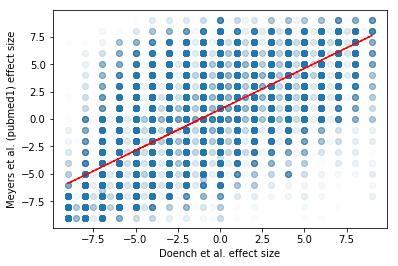

In [13]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

plt.scatter(joined["effect_x"], joined["effect_y"], alpha=0.02)
z = np.polyfit(joined["effect_x"], joined["effect_y"],1)
p = np.poly1d(z)
plt.plot(joined["effect_x"], p(joined["effect_x"]), "r--")

plt.xlabel("Doench et al. effect size")
plt.ylabel("Meyers et al. (pubmed1) effect size")

plt.show()

In [14]:
import scipy.stats as st
st.spearmanr(joined["effect_x"], joined["effect_y"])

SpearmanrResult(correlation=0.6638872742071942, pvalue=0.0)

In [15]:
joined.shape  #74088 - not right, there are only 71727 sequences in 

(74088, 6)

In [18]:
d["sequence"].to_csv("doench_seqs.csv", index=False)

In [11]:
# groupby sequence to get unique seqs
groupby_seq = toppub_grouped.groupby(['sequence']).count().reset_index()
groupby_gene = toppub_grouped.groupby(['symbol']).count().reset_index()

In [12]:
# keeping only sequence column
unique_seq_toppub = groupby_seq['sequence']
groupby_gene = groupby_gene['symbol']

In [13]:
# one_hot function

e_dict = {'A':[1,0,0,0], 'C':[0,1,0,0], 'G':[0,0,1,0], 'T':[0,0,0,1]}

def one_hot(x):
    return e_dict[x]

In [64]:
unique_seq_toppub.head()

0    AAAAAAATCCAGCAATGCAGAGG
1    AAAAAACCCGTAGATAGCCTCGG
2    AAAAAAGAAGAAAAAACCAGAGG
3    AAAAAAGCTCAAGAAGGAGGCGG
4    AAAAAAGGCTGTAAAAGCGTGGG
Name: sequence, dtype: object

In [14]:
# onehot encode the unique seqs
one_hot_un_seq = unique_seq_toppub.apply(lambda x: map(one_hot, x))

In [15]:
x = one_hot_un_seq

In [16]:
# reset indices
unique_seq_toppub = unique_seq_toppub.reset_index()
one_hot_un_seq = one_hot_un_seq.reset_index()
groupby_gene = groupby_gene.reset_index()

In [17]:
# append onehot to seqs
unique_seq_toppub['one_hot'] = one_hot_un_seq['sequence']

In [18]:
unique_seq_toppub.head()

,index,sequence,one_hot
0,0,AAAAAAATCCAGCAATGCAGAGG,"[[1, 0, 0, 0], [1, 0, 0, 0], [1, 0, 0, 0], [1,..."
1,1,AAAAAACCCGTAGATAGCCTCGG,"[[1, 0, 0, 0], [1, 0, 0, 0], [1, 0, 0, 0], [1,..."
2,2,AAAAAAGAAGAAAAAACCAGAGG,"[[1, 0, 0, 0], [1, 0, 0, 0], [1, 0, 0, 0], [1,..."
3,3,AAAAAAGCTCAAGAAGGAGGCGG,"[[1, 0, 0, 0], [1, 0, 0, 0], [1, 0, 0, 0], [1,..."
4,4,AAAAAAGGCTGTAAAAGCGTGGG,"[[1, 0, 0, 0], [1, 0, 0, 0], [1, 0, 0, 0], [1,..."


In [19]:
# merge one hot encoding to data
toppub_one_hot = toppub_grouped.merge(unique_seq_toppub,left_on="sequence",right_on="sequence", how="left")

In [20]:
# merge gene encoding to data
toppub_one_hot = toppub_one_hot.merge(groupby_gene,left_on="symbol",right_on="symbol", how="left")

In [35]:
toppub_one_hot.head()

,sequence,symbol,effect,index_x,one_hot,index_y
0,AAAAAAATCCAGCAATGCAGAGG,SHOC2,-1.0,0,"[[1, 0, 0, 0], [1, 0, 0, 0], [1, 0, 0, 0], [1,...",14001
1,AAAAAACCCGTAGATAGCCTCGG,NDUFA12,-1.0,1,"[[1, 0, 0, 0], [1, 0, 0, 0], [1, 0, 0, 0], [1,...",9936
2,AAAAAAGAAGAAAAAACCAGAGG,SDAD1,-5.0,2,"[[1, 0, 0, 0], [1, 0, 0, 0], [1, 0, 0, 0], [1,...",13701
3,AAAAAAGCTCAAGAAGGAGGCGG,FAM98A,1.0,3,"[[1, 0, 0, 0], [1, 0, 0, 0], [1, 0, 0, 0], [1,...",5316
4,AAAAAAGGCTGTAAAAGCGTGGG,ZNF253,-3.0,4,"[[1, 0, 0, 0], [1, 0, 0, 0], [1, 0, 0, 0], [1,...",17743


In [36]:
genecodes = toppub_all_data[['symbol', 'ensg']].drop_duplicates()

In [37]:
genecodes.head()

,symbol,ensg
13124697,A1BG,ENSG00000268895
13124700,A1BG,ENSG00000279611
13124701,A1CF,ENSG00000148584
13124705,A2M,ENSG00000175899
13124709,A2ML1,ENSG00000166535


In [53]:
# merge gene encoding to data
toppub_with_ensg = toppub_one_hot.merge(genecodes.drop_duplicates(subset=['symbol']), on="symbol", how="left")

In [54]:
toppub_with_ensg.shape

(72863, 7)

In [50]:
toppub_one_hot.shape

(72863, 6)

In [59]:
# split into training and testing for with gene, regression
np.random.seed(23)
msk = np.random.rand(len(toppub_with_ensg)) < 0.8
tmp = toppub_with_ensg[~msk]

np.random.seed(23)
msk = np.random.rand(len(tmp)) < 0.5
test_ensg = tmp[msk]

In [64]:
test_ensg[["symbol", "ensg"]].to_csv("../test_gene_ensg.csv", sep='\t')

In [63]:
test_ensg.shape   #matches the test pickle we made

(7338, 7)

In [15]:
# one hot features without gene
features_no_gene = np.ndarray(shape=(toppub_one_hot.shape[0],23,4), dtype=int)
for i in range(toppub_one_hot.shape[0]):
    for j in range(len(toppub_one_hot['one_hot'][i])):
        features_no_gene[i][j] = toppub_one_hot['one_hot'][i][j]

In [16]:
pickle.dump(features_no_gene, open("../features_no_gene.p", "wb"))

In [ ]:
features_no_gene.shape

In [17]:
# one hot features with gene
# create empty numpy matrix for storing one hot features
features = np.ndarray(shape=(toppub_one_hot.shape[0],23,5), dtype=int)
# append gene to each one hot nucleotide
for i in range(toppub_one_hot.shape[0]):
    for j in range(len(toppub_one_hot['one_hot'][i])):
        features[i][j] = toppub_one_hot['one_hot'][i][j] + [toppub_one_hot['index_y'][i]]

In [ ]:
features.shape

In [18]:
pickle.dump(features, open("../features.p", "wb"))

In [19]:
def convert_labels(y):
#     if y > 3:
#         return 1
#     else:
#         return 0
    return (y + 10)/float(20)

In [20]:
# regression labels
labels = toppub_one_hot['effect']
labels = np.array(list(map(lambda x: convert_labels(x), labels)))
# labels = np.eye(num_classes)[labels]

In [23]:
# classification labels
num_classes=21
labels_c = toppub_one_hot['effect']
# labels = np.array(list(map(lambda x: convert_labels(x), labels)))
labels_c = np.array(list(map(lambda x: int(x+10), labels_c)))
labels_c = np.eye(num_classes)[labels_c]

In [40]:
# 3-label classification labels
num_classes=3
labels_3 = toppub_one_hot['effect']
labels_3 = np.array(list(map(lambda x: int((x+10)/7), labels_3)))
labels_3 = np.eye(num_classes)[labels_3]

array([1, 1, 0, ..., 0, 2, 2])

In [39]:
#np.bincount(labels_3)

array([14388, 39995, 18480])

In [46]:
# split into training and testing for with gene, regression
np.random.seed(23)
msk = np.random.rand(len(features)) < 0.8

train_data = features[msk]
train_labels = labels[msk]

test_val_data = features[~msk]
test_val_labels = labels[~msk]

np.random.seed(23)
msk = np.random.rand(len(test_val_data)) < 0.5
test_data = test_val_data[msk]
test_labels = test_val_labels[msk]

val_data = test_val_data[~msk]
val_labels = test_val_labels[~msk]

# for with gene, regression
pickle.dump(train_data, open("../train_data_GR.p", "wb"))
pickle.dump(train_labels, open("../train_labels_GR.p", "wb"))

pickle.dump(test_data, open("../test_data_GR.p", "wb"))
pickle.dump(test_labels, open("../test_labels_GR.p", "wb"))

pickle.dump(val_data, open("../val_data_GR.p", "wb"))
pickle.dump(val_labels, open("../val_labels_GR.p", "wb"))

In [45]:
# split into training and testing for no gene, regression
np.random.seed(23)
msk = np.random.rand(len(features_no_gene)) < 0.8

train_data = features_no_gene[msk]
train_labels = labels[msk]

test_val_data = features_no_gene[~msk]
test_val_labels = labels[~msk]

np.random.seed(23)
msk = np.random.rand(len(test_val_data)) < 0.5
test_data = test_val_data[msk]
test_labels = test_val_labels[msk]

val_data = test_val_data[~msk]
val_labels = test_val_labels[~msk]

# for with no gene, regression
pickle.dump(train_data, open("../train_data_NR.p", "wb"))
pickle.dump(train_labels, open("../train_labels_NR.p", "wb"))

pickle.dump(test_data, open("../test_data_NR.p", "wb"))
pickle.dump(test_labels, open("../test_labels_NR.p", "wb"))

pickle.dump(val_data, open("../val_data_NR.p", "wb"))
pickle.dump(val_labels, open("../val_labels_NR.p", "wb"))

In [47]:
# split into training and testing for with gene, 21 classes
np.random.seed(23)
msk = np.random.rand(len(features)) < 0.8

train_data = features[msk]
train_labels = labels_c[msk]

test_val_data = features[~msk]
test_val_labels = labels_c[~msk]

np.random.seed(23)
msk = np.random.rand(len(test_val_data)) < 0.5
test_data = test_val_data[msk]
test_labels = test_val_labels[msk]

val_data = test_val_data[~msk]
val_labels = test_val_labels[~msk]

# for with gene, regression
pickle.dump(train_data, open("../train_data_G21.p", "wb"))
pickle.dump(train_labels, open("../train_labels_G21.p", "wb"))

pickle.dump(test_data, open("../test_data_G21.p", "wb"))
pickle.dump(test_labels, open("../test_labels_G21.p", "wb"))

pickle.dump(val_data, open("../val_data_G21.p", "wb"))
pickle.dump(val_labels, open("../val_labels_G21.p", "wb"))

In [48]:
# split into training and testing for with gene, 3 classes
np.random.seed(23)
msk = np.random.rand(len(features)) < 0.8

train_data = features[msk]
train_labels = labels_3[msk]

test_val_data = features[~msk]
test_val_labels = labels_3[~msk]

np.random.seed(23)
msk = np.random.rand(len(test_val_data)) < 0.5
test_data = test_val_data[msk]
test_labels = test_val_labels[msk]

val_data = test_val_data[~msk]
val_labels = test_val_labels[~msk]

# for with gene, regression
pickle.dump(train_data, open("../train_data_G3.p", "wb"))
pickle.dump(train_labels, open("../train_labels_G3.p", "wb"))

pickle.dump(test_data, open("../test_data_G3.p", "wb"))
pickle.dump(test_labels, open("../test_labels_G3.p", "wb"))

pickle.dump(val_data, open("../val_data_G3.p", "wb"))
pickle.dump(val_labels, open("../val_labels_G3.p", "wb"))

In [49]:
# split into training and testing for no gene, 21 classes
np.random.seed(23)
msk = np.random.rand(len(features_no_gene)) < 0.8

train_data = features_no_gene[msk]
train_labels = labels_c[msk]

test_val_data = features_no_gene[~msk]
test_val_labels = labels_c[~msk]

np.random.seed(23)
msk = np.random.rand(len(test_val_data)) < 0.5
test_data = test_val_data[msk]
test_labels = test_val_labels[msk]

val_data = test_val_data[~msk]
val_labels = test_val_labels[~msk]

# for with no gene, regression
pickle.dump(train_data, open("../train_data_N21.p", "wb"))
pickle.dump(train_labels, open("../train_labels_N21.p", "wb"))

pickle.dump(test_data, open("../test_data_N21.p", "wb"))
pickle.dump(test_labels, open("../test_labels_N21.p", "wb"))

pickle.dump(val_data, open("../val_data_N21.p", "wb"))
pickle.dump(val_labels, open("../val_labels_N21.p", "wb"))

In [50]:
# split into training and testing for no gene, 3 classes
np.random.seed(23)
msk = np.random.rand(len(features_no_gene)) < 0.8

train_data = features_no_gene[msk]
train_labels = labels_3[msk]

test_val_data = features_no_gene[~msk]
test_val_labels = labels_3[~msk]

np.random.seed(23)
msk = np.random.rand(len(test_val_data)) < 0.5
test_data = test_val_data[msk]
test_labels = test_val_labels[msk]

val_data = test_val_data[~msk]
val_labels = test_val_labels[~msk]

# for with no gene, regression
pickle.dump(train_data, open("../train_data_N3.p", "wb"))
pickle.dump(train_labels, open("../train_labels_N3.p", "wb"))

pickle.dump(test_data, open("../test_data_N3.p", "wb"))
pickle.dump(test_labels, open("../test_labels_N3.p", "wb"))

pickle.dump(val_data, open("../val_data_N3.p", "wb"))
pickle.dump(val_labels, open("../val_labels_N3.p", "wb"))

In [51]:
print(train_data.shape)
print(test_data.shape)
print(val_data.shape)

(58385, 23, 4)
(7338, 23, 4)
(7140, 23, 4)


In [26]:
# for with gene
pickle.dump(train_data, open("../train_data.p", "wb"))
pickle.dump(train_labels, open("../train_labels.p", "wb"))

pickle.dump(test_data, open("../test_data.p", "wb"))
pickle.dump(test_labels, open("../test_labels.p", "wb"))

pickle.dump(val_data, open("../val_data.p", "wb"))
pickle.dump(val_labels, open("../val_labels.p", "wb"))

In [73]:
# for classification without gene
pickle.dump(train_data, open("../train_data2.p", "wb"))
pickle.dump(train_labels, open("../train_labels2.p", "wb"))

pickle.dump(test_data, open("../test_data2.p", "wb"))
pickle.dump(test_labels, open("../test_labels2.p", "wb"))

pickle.dump(val_data, open("../val_data2.p", "wb"))
pickle.dump(val_labels, open("../val_labels2.p", "wb"))